[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Joshbazz/Neural_Network_Trading_Algo/blob/main/main.ipynb)


In [1]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from IPython.display import Image, display
# !pip install backtesting
from backtesting import Backtest, Strategy

In [2]:
class StockPricePrediction:
    def __init__(self, data_path, window_size=40):
        self.data_path = data_path
        self.window_size = window_size
        self.model = None
        self.scaler = RobustScaler()
        self.y_scaler = RobustScaler()
    
    def load_and_preprocess_data(self):
        data = pd.read_csv(self.data_path, parse_dates=True, index_col='Date')
        data_create = data['Close'].copy()
        return data, data_create

    def create_dataset(self, prices):
        data = []
        for i in range(len(prices) - self.window_size):
            X = prices[i:i + self.window_size]
            y = prices.iloc[i + self.window_size]
            data.append(list(X) + [y])
        columns = [f't-{i}' for i in range(self.window_size, 0, -1)] + ['t']
        return pd.DataFrame(data, columns=columns)

    def normalize_data(self, X_train, y_train):
        self.scaler.fit(X_train)
        X_train_scaled = self.scaler.transform(X_train)
        y_train = y_train.values.reshape(-1, 1)
        self.y_scaler.fit(y_train)
        y_train_scaled = self.y_scaler.transform(y_train)
        return X_train_scaled, y_train_scaled

    def inverse_transform(self, y_scaled, predictions_scaled):
        y_inv = self.y_scaler.inverse_transform(y_scaled).flatten()
        predictions_inv = self.y_scaler.inverse_transform(predictions_scaled).flatten()
        return y_inv, predictions_inv

    def build_model(self):
        model = Sequential()
        model.add(Dense(10, input_dim=self.window_size, activation='relu'))
        model.add(Dense(10, activation='relu'))
        # model.add(Dense(10, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer=SGD(learning_rate=0.001), loss='mean_squared_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
        self.model = model

    def train_model(self, X_train_scaled, y_train_scaled, epochs=50):
        self.model.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=32, validation_split=0.2, verbose=1)

    def evaluate_model(self, X_test_scaled, y_test_scaled):
        loss = self.model.evaluate(X_test_scaled, y_test_scaled, verbose=2)
        predictions = self.model.predict(X_test_scaled)
        return loss, predictions

    def save_model(self, epochs):
        current_timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        model_path = f'{current_timestamp}_stock_price_prediction_model_epochs_{epochs}.keras'
        self.model.save(model_path)
        print("Model saved successfully.")
        return model_path

In [3]:
def generate_signal(model_path, data_path, test_size, window_size=40):
    # Load the saved model
    model = load_model(model_path)

    # Load new data for backtesting
    new_data = pd.read_csv(data_path, parse_dates=True, index_col='Date')

    # Calculate the index for splitting into 75% training and 25% testing
    split_index = int(len(new_data) * (1 - test_size))

    # Split the data into training and testing sets
    data = new_data.iloc[split_index:]
    data = data.dropna()
    prices = data['Close'].copy()

    print(type(prices))

    # Preprocess the new data using the same window size as during training
    def create_backtest_data(prices, window_size):
        data = []
        for i in range(len(prices) - window_size):
            X_new = prices.iloc[i:i + window_size]
            y = prices.iloc[i + window_size]
            data.append(list(X_new) + [y])
        columns = [f't-{i}' for i in range(window_size, 0, -1)] + ['t']
        return pd.DataFrame(data, columns=columns)

    dataset = create_backtest_data(prices, window_size)

    # Assign target and feature sets
    X = dataset.iloc[:, :-1]
    y = dataset.iloc[:, -1].values.reshape(-1, 1)

    # Normalize features (using the same scaler as during training)
    scaler = RobustScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)

    scaler_y = RobustScaler()
    scaler_y.fit(y)
    y_scaled = scaler_y.transform(y)

    # Predict with the model
    predictions_scaled = model.predict(X_scaled)

    # Inverse transform predictions to get unscaled prices
    predictions = scaler_y.inverse_transform(predictions_scaled).flatten()

    # Implement trading strategy based on unscaled predictions
    positions = []
    current_position = 0

    for i in range(len(predictions)):
        # Buy if predicted close for the next day is higher than current day's open
        if predictions[i] > data['Open'].iloc[i + window_size] and current_position <= 0:
            positions.append(1)  # 1 indicates BUY
            current_position += 1
        # Sell if predicted close for the next day is lower than current day's open
        elif predictions[i] < data['Open'].iloc[i + window_size]:
            if current_position > 0:
                positions.append(-1)  # -1 indicates SELL
                current_position = 0
            else:
                positions.append(0)  # 0 indicates no action
        else:
            positions.append(0)  # No action if none of the conditions are met

    # Handle last day: sell remaining position if any
    if current_position > 0:
        positions.append(-1)

    # Adjust data to match the length of positions
    data_adjusted = data.iloc[window_size:].copy()

    # Ensure positions length matches data_adjusted length
    positions = positions[:len(data_adjusted)]

    # Add positions to the adjusted DataFrame
    data_adjusted['Signal'] = positions

    # Get the current timestamp and format it
    current_timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

    # Save new_data with positions
    data_adjusted.to_csv(f'{current_timestamp}_new_data_with_positions.csv', index=True)

    print(f"Data shape: {data_adjusted.shape}")
    print(f"Positions length: {len(positions)}")

    data_string = f'{current_timestamp}_new_data_with_positions.csv'

    return data_string

In [4]:
def save_and_visualize_model(model_path):

    model = load_model(model_path)

    # Generate a timestamp for the model file
    timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

    # Define the image path in the current directory
    img_path = f"model_{timestamp}.png"
    print(f"Saving model visualization to: {img_path}")

    # Plot the model and save it as a PNG image
    plot_model(
        model,
        to_file=img_path,
        show_shapes=True,
        show_dtype=False,
        show_layer_names=True,
        rankdir="TB",
        expand_nested=False,
        dpi=200,
        show_layer_activations=True,
        show_trainable=True
    )

    # Display the image
    img = Image(filename=img_path)
    display(img)
    print(f"Model visualization saved and displayed from {img_path}")


In [5]:
class SignalStrategy(Strategy):
    def init(self):
        self.signal = self.data.Signal

    def next(self):
        current_signal = self.data.Signal[-1]
        current_date = self.data.index[-1]
        print(f"Date: {current_date}, Current position size: {self.position.size}, Signal: {current_signal}, Position: {self.position.is_long}")
        
        if current_signal == 1:
            print("Executing BUY order")
            self.buy(size=1)
        elif current_signal == -1 and self.position.is_long:
            print("Attempting to SELL entire position")
            try:
                self.position.close()  # This closes the entire position
                print("SELL order executed - entire position closed")
            except Exception as e:
                print(f"Error executing SELL order: {e}")
        elif current_signal == 0:
            print("No trade executed")

def run_backtest(data_path, cash=1_000_000, commission=0.002, trade_on_close=True):
    # Load and preprocess the data
    dataframe = pd.read_csv(data_path, index_col='Date', parse_dates=True)
    dataframe = dataframe.sort_index()
    dataframe = dataframe.dropna()
    dataframe = dataframe.drop_duplicates()

    # Rename the columns to match the required format
    dataframe.columns = [column.capitalize() for column in dataframe.columns]

    # Initialize and run the backtest
    bt = Backtest(dataframe, SignalStrategy, cash=cash, commission=commission, trade_on_close=trade_on_close)
    stats = bt.run()

    # Print the statistics and plot the backtest results
    print(stats)
    bt.plot()

In [6]:
def fetch_and_save_data(ticker, start_date, end_date, file_path):

    # Fetch the historical data
    data = yf.download(ticker, start=start_date, end=end_date)
    
    # Save the data to a CSV file
    data.to_csv(file_path)
    
    print(f"Data for {ticker} from {start_date} to {end_date} has been saved to {file_path}")


[*********************100%%**********************]  1 of 1 completed

Data for ^STI from 2010-01-01 to 2017-01-03 has been saved to ^STI_data_end_2017-01-03_start_2010-01-01.csv
Epoch 1/50



/opt/anaconda3/envs/dev/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7531 - mean_absolute_percentage_error: 325.4330 - val_loss: 0.6356 - val_mean_absolute_percentage_error: 166.2071
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - loss: 0.5511 - mean_absolute_percentage_error: 282.0077 - val_loss: 0.4583 - val_mean_absolute_percentage_error: 145.3783
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 0.3986 - mean_absolute_percentage_error: 161.1550 - val_loss: 0.3626 - val_mean_absolute_percentage_error: 130.1964
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 0.3196 - mean_absolute_percentage_error: 182.5565 - val_loss: 0.3088 - val_mean_absolute_percentage_error: 121.8338
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2808 - mean_absolute_percentage_error: 153.1079 - val_loss: 0.2731 - val_mean_absolute_percentage_error: 116.2442
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 0.2582 - mean_absolute_percentage_error: 184.9758 - val_loss: 0.2476 - va

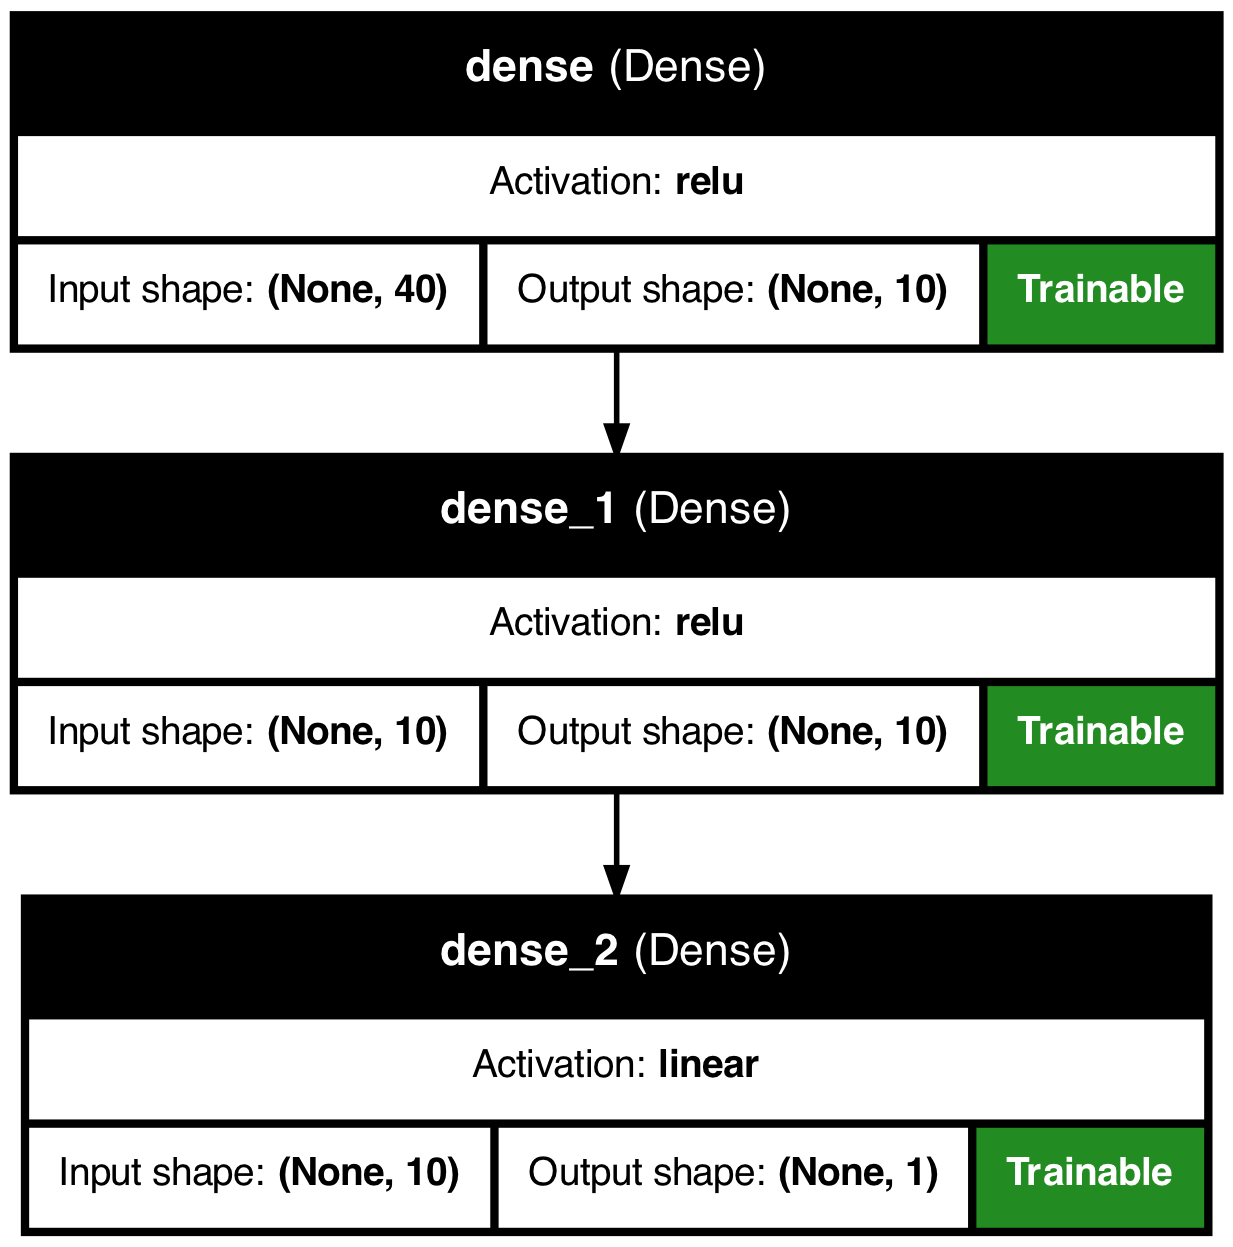

Model visualization saved and displayed from model_2024_07_01_13_20_02.png
<class 'pandas.core.series.Series'>
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Data shape: (396, 7)
Positions length: 396
Date: 2015-06-05 00:00:00, Current position size: 0, Signal: 0, Position: False
No trade executed
Date: 2015-06-08 00:00:00, Current position size: 0, Signal: 0, Position: False
No trade executed
Date: 2015-06-09 00:00:00, Current position size: 0, Signal: 0, Position: False
No trade executed
Date: 2015-06-10 00:00:00, Current position size: 0, Signal: 0, Position: False
No trade executed
Date: 2015-06-11 00:00:00, Current position size: 0, Signal: 0, Position: False
No trade executed
Date: 2015-06-12 00:00:00, Current position size: 0, Signal: 0, Position: False
No trade executed
Date: 2015-06-15 00:00:00, Current position size: 0, Signal: 0, Position: False
No trade executed
Date: 2015-06-16 00:00:00, Current position size: 0, Signal: 0, Position: False
No trade executed
Date: 2015-06-17 00:00

/opt/anaconda3/envs/dev/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/opt/anaconda3/envs/dev/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/opt/anaconda3/envs/dev/lib/python3.10/site-packages/backtesting/_plotting.py:455: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = (df.assign(_width=1).set_index('datetime')
/opt/anaconda3/envs/dev/lib/python3.10/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/opt/anaconda3/envs/dev/lib/python3.10/site-packages/backtesting/_pl

In [7]:
# Example usage
# Define the data path
ticker = '^STI'  # Example ticker
start_date = '2010-01-01'
end_date = '2017-01-03'
file_path = f'{ticker}_data_end_{end_date}_start_{start_date}.csv'

# fetch data from Yahoo Finance and save to CSV
fetch_and_save_data(ticker, start_date, end_date, file_path)

# Create an instance of the class
stock_predictor = StockPricePrediction(file_path)

# set the test_size. if test size is .25, then 75% of data will be used to train
test_size = 0.25

# Load and preprocess data
# train_percent [0,1] => determines percent of data that goes to training
data, data_create = stock_predictor.load_and_preprocess_data()

# Create dataset
dataset = stock_predictor.create_dataset(data_create)
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# retain X_test slice of original dataframe
backtest_data = data.iloc[-len(X_test):].copy()

# Normalize data
X_train_scaled, y_train_scaled = stock_predictor.normalize_data(X_train, y_train)
X_test_scaled, y_test_scaled = stock_predictor.scaler.transform(X_test), stock_predictor.y_scaler.transform(y_test.values.reshape(-1, 1))

# Build and train model
stock_predictor.build_model()
stock_predictor.train_model(X_train_scaled, y_train_scaled, epochs=50)

# # Evaluate model
loss, predictions = stock_predictor.evaluate_model(X_test_scaled, y_test_scaled)

# Inverse transform predictions and actual values
y_test_inv, predictions_inv = stock_predictor.inverse_transform(y_test_scaled, predictions)

# Save the model
model_path = stock_predictor.save_model(epochs=50)

# uncomment when bug fixed
save_and_visualize_model(model_path)

# Generate Signals csv
signals_string = generate_signal(model_path, file_path, test_size)

# Call the function with the path to your CSV file
run_backtest(signals_string)